# CAM 만들기

### 루브릭
1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?  
ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.  
  
2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?  
CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.  
  
3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?  
CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.  

### 접근 방식
- 셀 단위 혹은 함수 단위, 표현 단위로 코드를 한번 본 다음에 외워서 적어보자
- 코드 설명을 최대한 자세하게(불필요하다 생각할 정도로) 달아보자

### import 및 데이터 불러오기

In [1]:
# tensorflow, keras import
import tensorflow as tf
from tensorflow import keras

import numpy as np
# 그림+좌표출력을 위해 matplotlib사용
import matplotlib.pyplot as plt

# 데이터 로딩을 위한 tfds
import tensorflow_datasets as tfds

# 이미지를 다루기 위한 작업들
import copy
import cv2
from PIL import Image

#### 데이터 로딩(tfds.load)
  
tfds.load: 데이터셋을 불러온다. 경로를 지정하지 않으면 지정된 아카이브에서 받아오는 것으로 보인다.  
'stanford_dogs' 데이터셋의 이름  
split: 데이터를 나누어 받도록 만든다. 이 코드에서는 'train'과 'test'로 나누며 ds_train와 ds_test에 각각 나누어 할당된다.  
shuffle_files: 데이터 할당시 shuffle진행 여부를 결정한다.  
with_info: 데이터와 관련된 메타데이터들을 받을지 결정한다. 코드에서는 ds_info로 전달받는다.  

In [2]:
(ds_train, ds_test), ds_info= tfds.load('stanford_dogs',
                                        split=['train', 'test'],
                                        shuffle_files=True,
                                        with_info=True,
                                       )

#### tfds.show_examples(ds_train, ds_info)  
받은 데이터의 sample을 출력한다(무작위로)  
ds_train은 이미지 데이터를 불러오기 위함이고,  
ds_info는 이미지의 label정보를 불러오기 위함이다.(필수 파라미터다.)

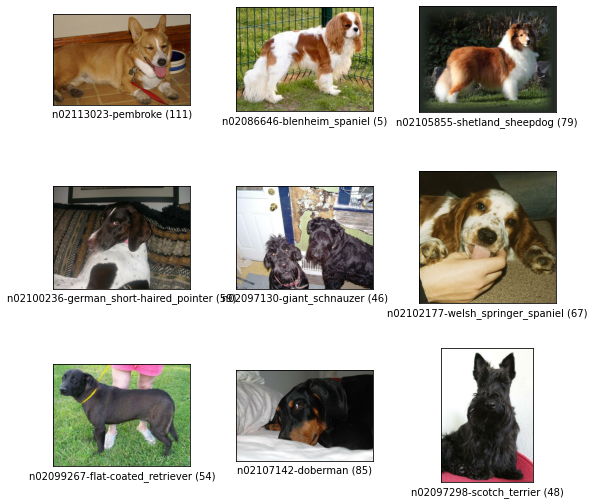

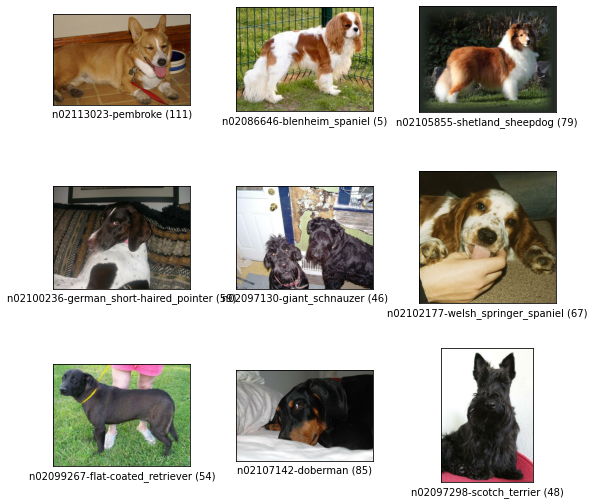

In [3]:
tfds.show_examples(ds_train, ds_info)

#### ds_info와 tfds.core.DatasetInfo
ds_info는 tfds.core.DatasetInfo 클래스의 instance다.  
tfds.core.DatasetInfo에서 데이터에 대한 정보(메타데이터)를 확인할 수 있다.  
features에는 dict형태로 데이터들의 shape과 type을 확인할 수 있다.  
여기서 image가 None, None, 3인 이유는 이미지의 크기가 다양하기 때문에 None으로 표기하며,   
rgb채널의 수는 모두 3이기 때문에 3으로 표기한다.  
label의 경우 class가 120가 존재함을 알 수 있으며,   
object detection을 염두에 두었는지 bbox가 존재함을 알 수 있었다.

In [4]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

tfds.core.DatasetInfo에서는 dataset에 대한 설명이나(description)  
총 용량 등도 확인할 수 있다.(dataset_size)
아래 링크는 DatasetInfo 객체가 가진 attribute들을 확인할 수 있다.
https://www.tensorflow.org/datasets/api_docs/python/tfds/core/DatasetInfo#attributes

In [5]:
# dataset에 대한 설명
ds_info.description

'The Stanford Dogs dataset contains images of 120 breeds of dogs from around\nthe world. This dataset has been built using images and annotation from\nImageNet for the task of fine-grained image categorization. There are\n20,580 images, out of which 12,000 are used for training and 8580 for\ntesting. Class labels and bounding box annotations are provided\nfor all the 12,000 images.'

In [6]:
# 총 용량
ds_info.dataset_size

744.72 MiB

### 데이터 전처리

#### normalize_and_resize_img

말 그대로 이미지의 크기를 바꾸고 normalize를 진행하는 함수.
apply_normalize_on_dataset에서 map method를 사용하기 때문에 실제 input 값은 Dataset에서 할당된 dict type의 변수가 들어가며, dict의 value는 위의 FeaturesDict의 값이 들어가는 것을 확인하였다.  
tf.image.resize()에서는 이미지의 size를 조절하며, 
픽셀 값은 RGB형태의 0-255의 정수값을 가지기 때문에 0~1로 만들어주기 위해 float32값으로 casting한 다음 255.0으로 나눠주었다.  
  
#### apply_normalize_on_dataset
  
tf.Dataset 형태의 데이터의 전처리를 적용하는 함수.  
ds.map()은 Dataset내부의 데이터(원소) 각각을 입력으로 하는 함수를 실행시킨다. pandas의 apply와 유사하다 볼 수 있다.  
여기서 num_parallel_calls는 비동기식 병렬 연산 지원 여부를 결정하는 값이며, 기본값은 None으로 순차적 연산이 이루어지지만 정수값을 입력할 경우 한번에 두개의 데이터에 대해(적어도 개념적으로는...) 연산이 동시에 이루어지며, 여기서 '비동기식'의 의미는 두 연산이 동시에 시작하고 끝나지 않는다는 것, 즉, 어느 한쪽이 연산이 끝났다고 다른 쪽을 기다렸다 연산을 끝내지 않는다는 것을 의미한다.  
  
ds.batch()는 Dataset내부적으로 batch_size 크기를 지닌 batch(한번에 연산하는 데이터 묶음)을 만들어준다.  
  
ds.prefetch()는 하나의 데이터가 작업되는 동안 다른 데이터의 작업을 준비하도록 만든다. 함수 선언시 매개변수의 이름은 batch인데, 코드에서는 tf.data.experimental.AUTOTUNE을 통해 tensorflow가 알아서 동적으로 batch를 잡도록 만들어 두었다.  
참골, 위의 batch와 같은 크기인지 아닌지는 확인하지 못했다. 물론 단순하게 생각하면 'batch 크기만큼 한번에 실행되어야 하니까 데이터 작업 준비도 같은 단위로 이루어져야 하는 것이 아닌가?'라고 생각할 수 있지만 batch 크기만큼 한번에 '실행'되는 것과 그것의 '준비'가 다른 크기의 batch로 이루어질 가능성도 배제할 수 없기 때문이다.


In [7]:
def normalize_and_resize_img(input):
    image=tf.image.resize(input['image'], [224, 224])
    input['image']= tf.cast(image, tf.float32)/255.
    return input['image'], input['label']

In [8]:
def apply_normalize_on_dataset(ds, batch_size=16):
    ds=ds.map(normalize_and_resize_img,
              num_parallel_calls=2)
    ds=ds.batch(batch_size)
    ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
# 함수를 적용시켜 normalize, resize, batch work를 진행하였다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 결과를 눈으로 확인, take는 데이터셋 일부를 추출하는 것처럼 보이지만
# 엄밀히 따지면 기존 Dataset을 기준으로 새로운 Dataset을 생성하는 메소드이며, 전달되는 인자(정수)의 크기만큼의 데이터를 가지고 있다.
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


### ResNet 설계
CAM을 위하여 사용할 backbone은 resnet50이다. 이미 설계된 것을 가져왔다.  
ds_info.features['label'].num_classes에서 class가 몇개인지 확인할 수 있다.  
  
이미 설계된 resnet50을 keras.applications.resnet50.Resnet50에서 가져온다. 각 매개변수의 역할은 다음과 같다.  
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50  
include_top은 Resnet50의 맨 마지막에 FC layer를 올릴지 말지를 결정하는 매개변수다. 처음에는 top이라 되어 있어서 '이미지 데이터를 입력받는데 왜 FC layer 옵션이 들어가지?'라 생각했는데, 찾아보니 맨 마지막 layer에 추가할지를 확인하는 옵션이었다. CAM에서는 불필요하므로 False로 설정하였다.  
weights는 resnet50에 대한 가중치를 가져오는데, 여기에서 'imagenet'을 입력할 경우 imagenet을 통하여 학습한 가중치들을 가져온다.(직접 훈련시킨 가중치도 가져올 수 있다.)  
input_shape는 말 그대로 어떤 shape의 input을 입력할지 결정한다.  
pooling은 pooling layer를 사용하는데 쓰이며, 'avg'는 GAP를 사용하겠다는 뜻이다.('max'면 global max pooling을 사용한다.)  
  
base_model.output은 base_model출력을 전달(구조를 Dense  
base_model.output을 할당받은 x는 Dense layer로 연결(resnet을 classifier이기 때문에 마지막으로 softmax를 사용하여 확률로 output을 출력하기 위해 사용)  
  
keras.Model()의 인자에 모델화시킬 입력과 최종 출력값을 전달하여 모델의 구성을 마친다.  

In [10]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [11]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

####  cam_model.compile
설계된 모델을 학습이 가능하도록 설정을 조절하는 단계라 생각하면 되겠다.  
각 매개변수(혹은 인자)의 역할은 다음과 같다.  
loss는 기준으로 삼을 손실함수를 지정한다. sparse categorical crossentropy는 주어진 label값이 one-hot encoding이 아닌 정수값으로 이루어졌기 때문에 적용하였다. one-hot encoding 형태였다면 categorical crossentropy를 적용했을 것이다.(둘의 차이는 입력 받는 label값이 one-hot encoding일 경우와 아닐 경우의 차이다. 어느쪽을 택하든 모델의 예측결과는 one-hot encoding이니 헷깔리지 않도록 하자)  
optimizer는 모델을 조정하는 방식을 지정한다. 원 코드에서는 SGD를 사용했지만, 그렇게 좋다는 adam을 적용하기로 하였다.

In [12]:
cam_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics='accuracy')

### 학습 시작- cam_model.fit
모델 설계와 설정이 끝났다면 fit()으로 학습을 실행시킨다.
각 매개변수(혹은 인자)의 역할은 다음과 같다.  
ds_train_norm은 훈련에 사용되는 데이터의 이름이다.  
steps_per_epoch은 1epoch이 돌아갈 때 batch를 몇번 적용할지를 정한다. 전체 훈련 데이터를 모델에 한 번 입력 및 학습시키는 것을 epoch이라 알고 있지만, 이 코드에서의 epoch은 훈련 단위에 불가하며, 사용자가 직접 몇 번의 batch가 1epoch으로 볼 것인지 결정할 수 있다. 기본값은 None이며 None이 들이갈 경우 1 epoch은 모든 데이터를 한 번씩 학습시킨다. 그렇기 때문에 코드 작성자가 한 것처럼 복잡한 수식을 적어 줄 필요가 있었나 싶다. 왜냐하면, int(ds_info.splits['train'].num_examples/16)은 (데이터 수/batch_size)이기 때문에 전체 값을 모두 학습시키는 None과 다를 바 없기 때문이다. 이는 버릇이거나, 좀 더 명시적으로 코드를 나타내기 위함인 것으로 추정한다.  
validation_steps는 1 epoch이 끝났을 때 validation set을 몇 batch나 사용할지를 말한다.  
즉, step_per_epoch이 '1 epoch동안 몇 개의 train data batch만큼 학습시킬래?'라고 물어보는 매개변수라면,  
validation_steps은 '1 epoch돌리면 몇 개의 validatin data batch만큼 예측 결과와 label 값을 비교해볼래?'라고 물어보는 것이다. 심지어 초깃값도 step_per_epoch처럼 None이고, None이면 모든 validation data를 사용하는 것조차 똑같다.  
epoch은 훈련 단위를 말한다.  
validation_data는 validation에 활용할 data를 정하는데 사용한다. 이번 과제에서는 validation과 test용 data를 혼용할 것이기 때문에 ds_test_norm을 입력하였다.  
verbose는 훈련 과정을 어떤 식으로 보여줄지를 결정한다. 0 입력시 아무 것도 보여주지 않고, 1 입력시 epoch별 진행 과정을 보여주며, 2 입력시 몇 epoch이나 진행되었는지를 보여준다. 흔히 사용하는 1을 입력하였다.  
use_multiprocessing은 동시의 여러 개의 thread(컴퓨터가 작업을 실행시키는 단위)를 사용할지 여부를 결정한다.(일종의 병렬 처리라고 생각하면 쉽다.)  

In [13]:
# 불필요하게 실행될 것은 방지하기 위해 주석처리
# history_cam_model = cam_model.fit(
#     ds_train_norm,
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=100,
#     validation_data=ds_test_norm,
#     verbose=1,
#     use_multiprocessing=True,
# )

몇시간 동안 훈련시킨 가중치를 저장하였다.  
os.getenv('HOME') 리눅스 커널 환경에서 HOME 디렉토리 경로를 가져오며, 거기에 추가로 경로를 붙여 훈련시킨 가중치를 더해주었다.  
아래에 사용하는 save()는 모델과 weight전체를 저장하며, 컴파일마저 할 필요가 없다.(용도에 따라 weight만 저장시키는 save_weight 같은 방식이나, 모델만 저장하거나 다양한 저장 방식이 있다.(https://vision-ai.tistory.com/entry/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%9A%B0%EC%9D%98-%EB%AA%A8%EB%8D%B8-weight%EA%B0%80%EC%A4%91%EC%B9%98-%EC%A0%80%EC%9E%A5%ED%95%98%EA%B3%A0-%EB%B6%88%EB%9F%AC%EC%98%A4%EA%B8%B0)  
  
<b>kernel reset 때문에 저장한 값을 불러울 경우 오래가 날 부분은 모두 주석 처리하였다.</b>

In [14]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model_basic_100epoch.h5'
# cam_model.save(cam_model_path)

#### 가중치 저장
저장 후, 현재 가중치를 다시 불러와 보았다.  
model.layers[2].get_weights()는 3번째(index는 0부터 시작해서 2) layer의 weight를 불러온다.  
tf.keras.models.load_model()은 경로의 model을 불러온다.

In [25]:
# 학습 직후 가중치
# weight가 제대로 저장되고 불러올 수 있는지 확인,
# cam_model.layers[2].get_weights()

In [16]:
loaded_model= tf.keras.models.load_model(cam_model_path)
loaded_model.layers[2].get_weights()

[array([[[[ 6.70696735e-01,  3.32439929e-01,  6.65550530e-02, ...,
            1.76370704e+00,  9.67778862e-01, -5.78257442e-01],
          [ 2.59481955e+00,  3.82949442e-01,  2.38663554e-01, ...,
            2.61264133e+00,  2.23736405e+00, -2.05999225e-01],
          [ 1.40282559e+00, -3.22529405e-01,  1.51170162e-03, ...,
            2.29390764e+00,  7.70620108e-01, -4.12739843e-01]],
 
         [[ 4.63921092e-02, -1.36301666e-01, -8.17938615e-03, ...,
            1.19617069e+00,  7.07879066e-01, -8.89709592e-01],
          [ 2.07255602e+00,  5.91258816e-02, -1.07407076e-02, ...,
            3.61046672e+00,  1.20423365e+00, -2.08873963e+00],
          [ 1.51963186e+00, -6.08865976e-01, -6.73512965e-02, ...,
            4.66177845e+00, -1.06578998e-01, -2.35930991e+00]],
 
         [[ 2.22877765e+00, -1.79300935e-03, -8.03787727e-03, ...,
            3.59787226e+00, -1.60167074e+00,  2.90283233e-01],
          [ 4.68791246e+00,  2.78379411e-01, -1.31207323e-02, ...,
            7.616

#### 히스토리 저장
뒤이어 학습 history 역시 저장해 보았다. 
(https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object)를 참고하였다.  
문제가 생겼다. kernel을 리셋한 다음 쓰기 부분을 주석처리 하지 않았더니 history 파일의 내용이 지워져 버린 것이다 ㅠㅠ  
안타깝지만 다시 history파일을 만들 수는 없으므로 다음 step인 CAM 만들기로 넘어가겠다.

In [19]:
import pickle
# with open(os.getenv('HOME')+'/aiffel/class_activation_map/cam_model_basic_100hist', 'wb') as hist_pkl:
#     pickle.dump(history_cam_model.history, hist_pkl)

In [20]:
# with open(os.getenv('HOME')+'/aiffel/class_activation_map/cam_model_basic_100hist', 'rb') as hist_pkl:
#     loaded_hist=pickle.load(hist_pkl)

간단하게 matplotlib 코드를 정리하였다.  
plt.plot()은 그래프에 들어갈 데이터를 입력하는 역할을 한다.  
plt.title()은 그래프 제목을 붙인다.  
plt.xlabel()과 plt.ylabel()은 각각 x, y축이 어떤 데이터인지 이름을 붙여준다.  
plt.legend()는 막대 그래프가 어떤 값을 의미하는지 다시 한번 설명한다. loc는 설명 패널의 위치를 정한다.  

In [21]:
# plt.plot(loaded_hist['loss'], 'r')
# plt.plot(loaded_hist['val_loss'], 'b')
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['loss', 'val_loss'], loc='upper left')
# plt.show()

In [22]:
# plt.plot(loaded_hist['accuracy'], 'g')
# plt.plot(loaded_hist['val_accuracy'], 'y')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Model accuracy')
# plt.legend(['accuracy', 'val_accuracy'])
# plt.show()

저장과 불러오기가 잘 되는 것을 확인하였으며, 아래의 코드는 맨 처음 학습시 사용한 코드로, 남아는 있어야 할 것 같아서 주석 처리한다.

In [23]:
# plt.plot(history_cam_model.history['loss'], 'r')
# plt.plot(history_cam_model.history['val_loss'], 'b')
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['loss', 'val_loss'], loc='upper left')
# plt.show()

In [24]:
# plt.plot(history_cam_model.history['accuracy'], 'g')
# plt.plot(history_cam_model.history['val_accuracy'], 'y')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Model accuracy')
# plt.legend(['accuracy', 'val_accuracy'])
# plt.show()

### CAM 만들기
이로서 CAM에 적용할 값들을 학습하고 저장 및 불러오기까지 마쳤지만, 결과는 만족스럽지 못했고, 이 모델을 사용하고 싶었지만 validation loss와 accuracy값은 부적절(수렴하지 않았다.)하였기 때문에 preset을 가져다 사용하기록 하였다.